In this tutorial, we utilize the Pytorch package, which is more flexible. Other package, such as Tensorflow, Keras can also be used for building deep learning models.

# Basic CNN to classify Image


## Pipeline
Training an image classifier
We will do the following steps in order:

1. Load and normalize the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolutional Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data


Using ``torchvision``, it’s extremely easy to load CIFAR10.

## Dataset Introduction

For this tutorial, we will use the CIFAR10 dataset. It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

### 1. Load and normalize CIFAR10

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Let us show some of the training images, for fun.



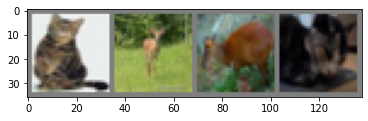

cat   deer  deer  cat  


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # move channel dimension to the last dimension
    # plt.imshow(npimg)  # move channel dimension to the last dimension

    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()  # batch size of 4

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

### 2. Define a Convolutional Neural Network

In [4]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)  
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # x shape [batch size, 3, 32, 32]
        x = self.pool(F.relu(self.conv1(x)))  # [batch size, 6, 14, 14]
        x = self.pool(F.relu(self.conv2(x)))  # [batch size, 16, 5, 5]
        x = torch.flatten(x, 1) # flatten all dimensions except batch # [batch size, 16 * 5 * 5]
        x = F.relu(self.fc1(x))  # [batch size, 120]
        x = F.relu(self.fc2(x))  # [batch size, 840]
        x = self.fc3(x)  # [batch size, 10]
        return x


net = Net()

### 3. Define a Loss function and optimizer

CrossEntropyLoss for multi-class classification

In [5]:
import torch.optim as optim

# CrossEntropyLoss for multi-class classification
criterion = nn.CrossEntropyLoss()
# Select SGD as the optimizer here. There are also other optimizers, such as Adam, RMSprop.
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

###4. Train the network

We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.

Training on GPU for acceleration
----------------
Just like how you transfer a Tensor onto the GPU, you transfer the neural
net onto the GPU.

Let's first define our device as the first visible cuda device if we have
CUDA available:


In [6]:
print(torch.cuda.is_available()) # where cuda can be used
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') # set the device

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

True
cuda:0


To use cuda, we need to transfer the network and data to the specificed device.

In [7]:
net = net.to(device) # transfer network to device
max_epochs = 2  # specify the maximum number of training epoches
net.train()
for epoch in range(max_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # transfer data to device
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()  # compute the gradient
        optimizer.step()  # apply the gradient

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0


print('Finished Training')

[1,  2000] loss: 2.246
[1,  4000] loss: 1.930
[1,  6000] loss: 1.703
[1,  8000] loss: 1.605
[1, 10000] loss: 1.551
[1, 12000] loss: 1.464
[2,  2000] loss: 1.421
[2,  4000] loss: 1.372
[2,  6000] loss: 1.350
[2,  8000] loss: 1.341
[2, 10000] loss: 1.295
[2, 12000] loss: 1.292
Finished Training


#### Let's quickly save our trained model:

In [8]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

### 5. Test the network on the test data

#### Test image samples

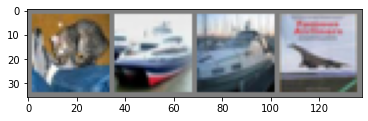

GroundTruth:  cat   ship  ship  plane


In [9]:
# print the sampled image
dataiter = iter(testloader)
images, labels = dataiter.next()  # batch size of 4
# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [10]:
# load the trained model
net = Net()
net.load_state_dict(torch.load(PATH))
net = net.to(device)

In [11]:
# get output of the image samples
outputs = net(images.to(device))
# get the predicted labels of these image samples
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  frog  ship  ship  ship 


#### Get accuracy on the whole dataset

In [12]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
net.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 53 %


The accuracy (54%) is better than random guess (10%).
There are many paremeters you can turn to increase the permance, such as the covolution kernal size, pooling size, number of layers, batch size.

# AlexNet

## Prepre dataset, alext net require the image size to be at least 224.


In [13]:
from torchvision.datasets import CIFAR10
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

#creating a dinstinct transform class for the train, validation and test dataset
tranform_train = transforms.Compose([transforms.Resize((227,227)), transforms.RandomHorizontalFlip(p=0.7), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
tranform_test = transforms.Compose([transforms.Resize((227,227)), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

#preparing the train, validation and test dataset
torch.manual_seed(43)
train_ds = CIFAR10("data/", train=True, download=True, transform=tranform_train) #40,000 original images + transforms
val_size = 10000 #there are 10,000 test images and since there are no transforms performed on the test, we keep the validation as 10,000
train_size = len(train_ds) - val_size
train_ds, val_ds = random_split(train_ds, [train_size, val_size]) #Extracting the 10,000 validation images from the train set
test_ds = CIFAR10("data/", train=False, download=True, transform=tranform_test) #10,000 images

#passing the train, val and test datasets to the dataloader
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=64, shuffle=False)
test_dl = DataLoader(test_ds, batch_size=64, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [14]:
len(train_ds)

40000

## A simple implementation of AlexNet

In [15]:
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels= 96, kernel_size= 11, stride=4, padding=0 )
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv2 = nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride= 1, padding= 2)
        self.conv3 = nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride= 1, padding= 1)
        self.conv4 = nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.fc1  = nn.Linear(in_features= 9216, out_features= 4096)
        self.fc2  = nn.Linear(in_features= 4096, out_features= 4096)
        self.fc3 = nn.Linear(in_features=4096 , out_features=10)


    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = self.maxpool(x)
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = self.maxpool(x)
        x = x.reshape(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## Train AlexNet

In [16]:
alex_net = AlexNet() #to compile the model
alex_net = alex_net.to(device=device) #to send the model for training on either cuda or cpu

## Loss and optimizer
learning_rate = 1e-4 #I picked this because it seems to be the most used by experts
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(alex_net.parameters(), lr= learning_rate) #Adam seems to be the most popular for deep learning

max_epochs = 2  # specify the maximum number of training epoches Here we only train 2 epoches
alex_net.train()
for epoch in range(max_epochs): 
    loss_ep = 0
    
    for batch_idx, (data, targets) in enumerate(train_dl):
        data = data.to(device=device)
        targets = targets.to(device=device)
        ## Forward Pass
        optimizer.zero_grad()
        scores = alex_net(data)
        loss = criterion(scores,targets)
        loss.backward()
        optimizer.step()
        loss_ep += loss.item()
    print(f"Loss in epoch {epoch} :::: {loss_ep/len(train_dl)}")

    with torch.no_grad():
        num_correct = 0
        num_samples = 0
        for batch_idx, (data,targets) in enumerate(val_dl):
            data = data.to(device=device)
            targets = targets.to(device=device)
            ## Forward Pass
            scores = alex_net(data)
            _, predictions = scores.max(1)
            num_correct += (predictions == targets).sum()
            num_samples += predictions.size(0)
        print(
            f"Got {num_correct} / {num_samples} with accuracy {float(num_correct) / float(num_samples) * 100:.2f}"
        )


print('Finished Training')

Loss in epoch 0 :::: 1.507835391521454
Got 5817 / 10000 with accuracy 58.17
Loss in epoch 1 :::: 1.0010260293006896
Got 6713 / 10000 with accuracy 67.13
Finished Training


## Test the AlexNet model

In [17]:
num_correct = 0
num_samples = 0
alex_net.eval()
for batch_idx, (data,targets) in enumerate(test_dl):
    data = data.to(device=device)
    targets = targets.to(device=device)
    ## Forward Pass
    scores = alex_net(data)
    _, predictions = scores.max(1)
    num_correct += (predictions == targets).sum()
    num_samples += predictions.size(0)
print(
    f"Got {num_correct} / {num_samples} with accuracy {float(num_correct) / float(num_samples) * 100:.2f}"
)

Got 6832 / 10000 with accuracy 68.32
